# Distributions

## Index

1. [Distributions](#Distributions)
2. [Probability Mass Function](#Probability-Mass-Function)
3. [The Cookie Problem Revisited](#The-Cookie-Problem-Revisited)
4. [101 Bowls](#101-Bowls)
5. [The Dice Problem](#The-Dice-Problem)
   5.1. [Updating dice](#Updating-dice)
6. [Summary](#Summary)
7. [Source](#Source)

In the previous chapter we used the Bayes's theorem to solve the cookie problem as well as others using a Bayes Table. In this chapter we will be expanding the examples but using a `pmf` (Probability Mass Function) to create a solution

## Distributions

in statistics a distribution is a set of possible outcomes and their corresponding probabilities. For Example, if you toss a coin, there are two possible outcomes with approximately equal probability.

To represent distributions, we'll use a library called `empiricaldist`. an "empirical" distribution is based on data, as opposed to a theoretical distribution. We will use this library throughout the book.

## Probability Mass Function

If the outcomes in a distribution are discrete, we can describe the distribution with a **probability mass function** (or PMF). which is a function that maps from each possible outcome to its probability.

`empiricaldist` provides a class called `Pmf` that represents a probability mass function. let's start working with it now:

In [1]:
from empiricaldist import Pmf
import numpy as np
import matplotlib.pyplot as plt

We can now create a pmf of the a coin toss:

In [2]:
coin = Pmf()
coin["heads"] = 1/2
coin["tails"] = 1/2
coin

,probs
heads,0.5
tails,0.5


In the example above we are defining the discrete outcomes of the pmf as well as the probability of each one. We can also get the probability to be generated based on lists and sequences (One will apply equal probabilities and one will calculate the probability). Lets see how this is done:

In [3]:
die = Pmf.from_seq([1,2,3,4,5,6])
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [4]:
letters = Pmf.from_seq(list('Mississippi'))
letters

,probs
M,0.090909
i,0.363636
p,0.181818
s,0.363636


As we can see the letters calculates the probability based on the number of occurrences of each letter while the dice has only one value for each side so the distribution is a uniform distribution

if we ever try to select a value out side of the Pmf using a Pandas subscript it will throw an error

In [5]:
try:
    letters["a"]
except Exception as e:
    print(e)
    print(type(e))

'a'
<class 'KeyError'>


But we can also call the probabilities as if it was a function which will return a 0 rather than an error:

In [6]:
letters("a")

0

Now that we have some of the basics down we can also see an example of how we can also call up multiple probabilities from the same pmf function. In this example let's fetch the probability of rolling a 1, 4 and a 7

In [7]:
die([1,4,7])

array([0.16666667, 0.16666667, 0.        ])

## The Cookie Problem Revisited

We will now use a pmf to solve the cookie problem, just for prosperity let's look at the statement of the problem again:

Suppose there are two bowls of cookies:
 - Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies.
 - Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.

Now suppose we pick one of the bowls at random and without looking choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

Here is the Pmf that represents the two hypothesis and their prior probabilities:

In [8]:
prior = Pmf.from_seq(["Bowl 1", "Bowl 2"])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


The distribution, which contains the prior probability for each hypothesis is called the Prior Distribution.

To update the distribution based on the new data we will multiple the priors by the likelihoods. We can do this now:

In [9]:
likelihood_vanilla = [30/40, 20/40]
posterior = prior* likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


The result that we achieve is the unnormalized posteriors so these won't sum up to 1. we can easily normalize them using a function provided by the Pmf

In [10]:
posterior.normalize()

0.625

This result of 0.625 is the total probability of the data but we also now have a variable called `posterior` which contains the posterior distribution as the `normalize` is inplace.

In [11]:
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


From this posterior we can either look at the full distribution or we can select the individual Bowls:

In [12]:
posterior("Bowl 1")

0.6

One of the benefits of using the Pmf is that it is easy to do successive updates with more data. For example lets look at a situation in which we put the first cookie back so the likelihoods have not changed and we draw from the same bowl again and also draw a vanilla cookie we can update the posterior probabilities of the successive event as the following:

In [13]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


Now the probability of the Bowl being Bowl 1 is nearly 70%. We can also do an example of putting the cookie back again and from the same Bowl drawing a chocolate cookie:

In [14]:
likelihood_chocolate = [10/40, 20/40]
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


Now the resulting posterior probability is approximately 53%. This is after drawing three cookies from the same bowl 2 of which are vanilla and one that is chocolate.

## 101 Bowls

We can now solve a cookie problem with 101 Bowls:
 - Bowl 0 contains 0% Vanilla cookies
 - Bowl 1 contains 1% Vanilla cookies
and so on up to:
 - Bowl 100 contains only vanilla cookies

as with our previous examples we will work under the assunption that there are only two kinds of cookies and the problem statement is the following:
Choose a bowl at random and a cookie at random from that bowl, the cookie turns out to be vanilla, what is the probability that the cookie came from Bowl x for each value of x?

To start solving the problem we first create out prior distribution:

In [15]:
x = np.arange(101)
prior = Pmf(1, x)
prior.normalize()

101

In the example we initialise the prior distribution with two values, the first one "1" is the prior probability and the second is the sequence of parameters. Since the probabilities are all the same we have to provide one of them which gets distributed amongst the Pmf, this distribution is a uniform distribution.

We can look at the first few probabilities using head:

In [16]:
prior.head()

,probs
0,0.009901
1,0.009901
2,0.009901


The likelihood is the fraction of vanilla cookies in each bowl which is easy to calculate at the bowl number is a reflection of this:

In [17]:
likelihood_vanilla = x / 100

We can now use the usual method to calulate the posterior probabilities

In [18]:
posterior = prior * likelihood_vanilla
posterior.normalize()
posterior.head()

,probs
0,0.000000
1,0.000198
2,0.000396


We can now graphically represent this ditribution as it is too many outcomes to look at the data alone. We will create a method to do this and use some tools from the `Pmf` class.

In [19]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

def decorate_bowls(title):
    decorate(xlabel='Bowl #',
             ylabel='PMF',
             title=title)

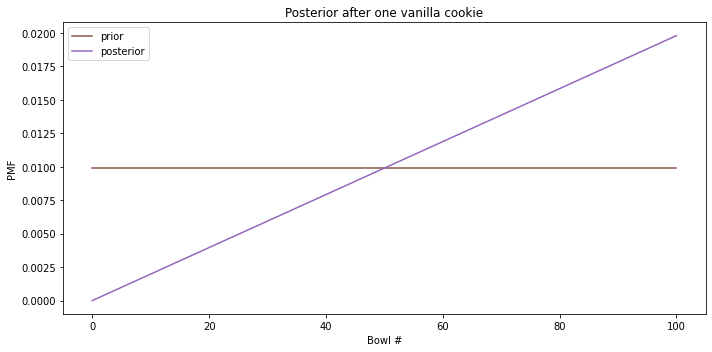

In [20]:
plt.figure(figsize=(10,5))
prior.plot(label='prior', color='C5')
posterior.plot(label='posterior', color='C4')
decorate_bowls('Posterior after one vanilla cookie')

The posterior probability of Bowl 0 is 0 as there is no Vanilla cookies and the probability of Bowl 100 is 100% as it is only Vanilla cookies. As the posteriors are proportional to the Bowl number we have a straight line for each posterior in the distribution.

Lets have a look and see what happens when we do an update and draw another vanilla cookie:

In [21]:
posterior2 = posterior * likelihood_vanilla
posterior2.normalize()

0.6699999999999999

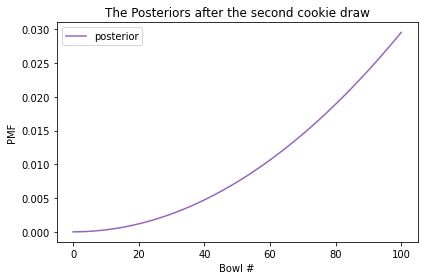

In [22]:
posterior2.plot(label = "posterior", color = "C4")
decorate_bowls("The Posteriors after the second cookie draw")

After the second draw we can see that the higher bowls have a lot higher posterior in comparison to the bowls that have a lower proportion of cookies in them. Let's follow the same example as before and draw a single Chocolate cookie:

In [23]:
likelihood_chocolate = 1 - x/100
posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

0.2462686567164179

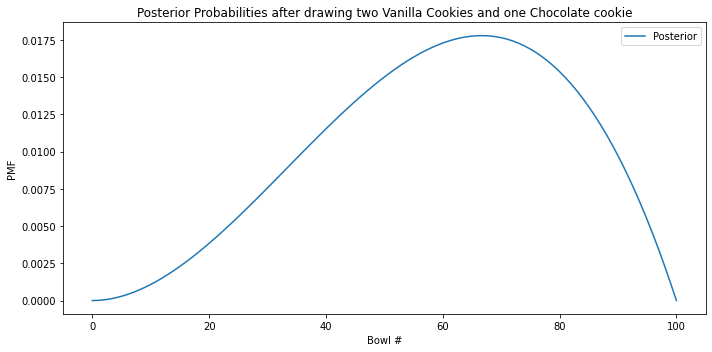

In [24]:
plt.figure(figsize=(10,5))
posterior3.plot(label="Posterior")
decorate_bowls("Posterior Probabilities after drawing two Vanilla Cookies and one Chocolate cookie")

We now get an interesting shape. As we can see Bowl 100 has a probability of 0% as there are no possible chocolate cookies in that bowl and the peak of the probabilities is closer to 67 which is the proportion of vanilla cookies we drew in comparison to the chocolate ones.

The quantity with the highest posterior probability is called the **MAP** which stands for the "maximum a posteori probability" where posteori is Latin for posterior.

to calculate the map we can use the following function `idxmax`

In [25]:
posterior3.idxmax()

67

And PMF provides a method which is a bit more memorable:

In [26]:
posterior3.max_prob()

67

We now get to the main point of this chapter, this exercise is not really about the number of cookies and bowls but rather about estimating proportions.

To see this lets look at it in a different way, lets say we have only one Bowl with an indeterminite proportion of cookies but we think that it is equally likely that the proportion lies between 0 and 1. We now draw three cookies and two of them are vanilla what proportion of the cookies are vanilla? The posterior distribution we just computed is the answer to that question.

Let's now revisit another problem we have explored before:

## The Dice Problem

We solved this in the previous chapter but lets use the Pmf solve it now, again just to keep everything together we will look at the question statement:

Suppose we have a box with a 6-sided die, an 8 sided-die and a 12-sided die. I choose one dice at random, roll it and report that the outcome is 1. What is the probability that I chose the 6-sided die?

In [27]:
prior = Pmf.from_seq([6, 8, 12])
likelihood_one = 1/6, 1/8, 1/12
posterior = prior * likelihood_one
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


From the Posterior distribution above we can see that the probability is 0.44 that we picked the 6 sided die based on rolling a 1. We roll the dice again and we get a 7, lets apply the update and see what happens:

In [28]:
likelihood_seven = 0/6, 1/8, 1/12
posterior *= likelihood_seven
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


We now have a zero probability of having picked up the 6 sided die as seven does not exist on the face but now the 8 sided die has the highest posterior probability. This is a lot of duplicated code for each result we get from the die so we can create a function that will do the update for us:

### Updating dice

The following function is a more general version of the update:

In [29]:
def update_dice(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In this method we call the qs function which returns the quantities of the distribution (the dice faces in our example) and then calculate the likelihood and set the likelihood to zero if the inserted value is greater than the faces on the die. We can now see this function in action:

In [30]:
pmf = prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


This is the prior distribution for the example and we can now use the new function we have created:

In [31]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692


## Summary

The chapter introduces the empericaldist module which provides us with the Pmf class for our calculations.

## Source

[Chapter 3](#https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/notebooks/chap03.ipynb#scrollTo=TTgtXhBZxwqq)

## Exercises

1. Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die. I choose one of the dice at random, roll it four times, and get 1, 3, 5, and 7. What is the probability that I chose the 8-sided die?

In [32]:
pmf = prior.copy()
update_dice(pmf, 1)
update_dice(pmf, 3)
update_dice(pmf, 5)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.835052
12,0.164948


2. Suppose the box contains 1 die that is 4-sided, 2 dice that are 6-sided, 3 dice that are 8-sided, 4 dice that are 12-sided, and 5 dice that are 20-sided. I choose a die, roll it, and get a 7. What is the probability that I chose an 8-sided die?

In [35]:
ps = [1,2,3,4,5]
qs = [4,6,8,12,20]

prior = Pmf(ps,qs)
prior.normalize()
pmf = prior.copy()


In [36]:
update_dice(pmf, 7)
pmf

,probs
4,0.000000
6,0.000000
8,0.391304
12,0.347826
20,0.260870


3. Suppose I have two sock drawers. One contains equal numbers of black and white socks. The other contains equal numbers of red, green, and blue socks. Suppose I choose a drawer at random, choose two socks at random, and I tell you that I got a matching pair. What is the probability that the socks are white?

In [38]:
hypos = ["Draw 1", "Draw 2"]
prior = Pmf(1/2, hypos)
likelihood_match = 1/2, 1/3
posterior = prior * likelihood_match
posterior.normalize()
posterior


,probs
Draw 1,0.6
Draw 2,0.4


In [39]:
# to get the probability with drawing a white sock:
posterior("Draw 1") / 2

0.30000000000000004